Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time  
https://arxiv.org/abs/2203.05482

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from sklearn import metrics

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
from my_utils import dotdict

In [ ]:
from wandb_sweep import get_dls, get_learner

In [ ]:
from model_eval import get_val_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [ ]:
import wandb

api = wandb.Api()

In [ ]:
def get_learners(config, sweep_ids):
    learners, f1_scores = [], []
    for sweep_id in sweep_ids:
        sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
        best_run_config = sweep.best_run().config
        learners.append(get_learner(config, dls, n_channels))
        learners[-1].load(f"{sweep_id}_run{best_run_config['experiment_no']}")
        f1_scores.append(sweep.best_run().summary['f1_score'])
    return learners, f1_scores

In [ ]:
def get_uniform_soup_weights(learners):
    model_keys = learners[0].model.state_dict().keys()
    average_model_dict = dict()

    for key in model_keys:
        average_model_dict[key] = torch.stack([learner.model.state_dict()[key] for learner in learners]).mean(dim=[0])
    return average_model_dict

In [ ]:
def evaluate_model(model_dict):
    learner = get_learner(config, dls, n_channels)
    learner.model.load_state_dict(model_dict)
    preds, targets, soft_preds, y_true, y_pred = get_val_preds(learner)
    acc = metrics.accuracy_score(y_true, y_pred) 
    f1 = metrics.f1_score(y_true, y_pred, average="macro")
    
    return acc, f1

In [ ]:
sweep_id = "1cesj6eh"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.test_evaluation = False

dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
sweep_ids = ['1cesj6eh', 's45fguzh', 'g1aqz63h', 'ire6sash', 'otphs2zh']

In [ ]:
for sweep_id in sweep_ids:
    sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
    best_run_config = sweep.best_run().config
    print(f"{sweep_id}_run{best_run_config['experiment_no']}")

wandb: Sorting runs by -summary_metrics.combined_f1_time
wandb: Sorting runs by -summary_metrics.combined_f1_time


1cesj6eh_run1


wandb: Sorting runs by -summary_metrics.combined_f1_time


s45fguzh_run4


wandb: Sorting runs by -summary_metrics.combined_f1_time


g1aqz63h_run4


wandb: Sorting runs by -summary_metrics.combined_f1_time


ire6sash_run5
otphs2zh_run5


### Uniform soup

In [ ]:
accs, f1s = [], []
for n_models in range(1, len(sweep_ids)+1):
    learners, _ = get_learners(config, sweep_ids[:n_models])
    average_model_dict = get_uniform_soup_weights(learners)
    acc, f1 = evaluate_model(average_model_dict)
    accs.append(acc)
    f1s.append(f1)

[<matplotlib.lines.Line2D>]

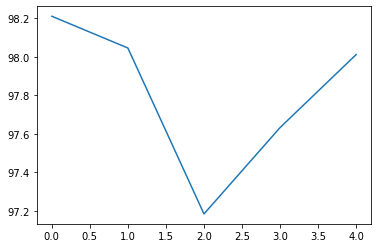

In [ ]:
plt.plot(f1s)

### Greedy soup

In [ ]:
def get_f1s_from_fnames(fnames):
    f1_scores = []
    for fname in fnames:
        sweep_id = fname.split('_')[0]
        run_no = int(fname.split('run')[1].split('.')[0])
        sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
        for run in sweep.runs:
            if run.config['experiment_no'] == run_no:
                f1_scores.append(run.summary['f1_score'])
                break
    return f1_scores

In [ ]:
from tqdm.notebook import tqdm

def get_greedy_soup_weights(fnames, f1_scores):
    sorted_fnames = sorted(zip(fnames, f1_scores), key=lambda x: x[1], reverse=True)
    
    fname = sorted_fnames[0][0]
    sweep_id = fname.split('_')[0]
    run_no = int(fname.split('run')[1].split('.')[0])
    learner1 = get_learner(config, dls, n_channels)
    learner2 = get_learner(config, dls, n_channels)
    learner1.load(f"{sweep_id}_run{run_no}")
    model_keys = learner1.model.state_dict().keys()
    
    greedy_soup_dict = learner1.model.state_dict()
    best_f1 = sorted_fnames[0][1]
    print(f'Model no. 0 ({fname}) added to greedy soup. \nBase F1 score: {best_f1:.5f}')
        
    for model_no in tqdm(range(1, len(sorted_fnames))):
        candidate_soup_dict = dict()
        
        fname = sorted_fnames[model_no][0]
        sweep_id = fname.split('_')[0]
        run_no = int(fname.split('run')[1].split('.')[0])
        
        learner2.load(f"{sweep_id}_run{run_no}")
        candidate_model_dict = learner2.model.state_dict()
        
        for key in model_keys:
            candidate_soup_dict[key] = (greedy_soup_dict[key] + candidate_model_dict[key]) / 2.
        
        _, f1 = evaluate_model(candidate_soup_dict)
        if f1 >= best_f1:
            best_f1 = f1
            print(f'Model no. {model_no} ({fname}) added to greedy soup. \nNew F1 score: {best_f1:.5f}')
            greedy_soup_dict = candidate_soup_dict
        else:
            print(f'Model no. {model_no} not added due to lower F1: {f1:.5f}')
            
    return greedy_soup_dict

In [ ]:
sweep_begins = ['1ces', '2tw', '9x92', 'g1aq', 'g31', 'gjnv', 'ire', 'kno', 'otp', 's45', 'zcg']

In [ ]:
fnames = []
for file in glob.glob('./models/*.pth'):
    for sweep_begin in sweep_begins:
        if (fname :=file.split('/')[-1]).startswith(sweep_begin):
             fnames.append(fname)

In [ ]:
f1_scores = get_f1s_from_fnames(fnames)

In [ ]:
sweep_id = "1cesj6eh"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.test_evaluation = False

dls, _, n_channels = get_dls(config)

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
greedy_soup_weights = get_greedy_soup_weights(fnames, f1_scores)

Model no. 0 (1cesj6eh_run1.pth) added to greedy soup. 
Base F1 score: 0.98210


  0%|          | 0/50 [00:00<?, ?it/s]

Model no. 1 not added due to lower F1: 0.97051


Model no. 2 not added due to lower F1: 0.96949


Model no. 3 not added due to lower F1: 0.97887


Model no. 4 not added due to lower F1: 0.97989


Model no. 5 not added due to lower F1: 0.95855


Model no. 6 not added due to lower F1: 0.96374


Model no. 7 not added due to lower F1: 0.96700


Model no. 8 not added due to lower F1: 0.96955


Model no. 9 not added due to lower F1: 0.97561


Model no. 10 not added due to lower F1: 0.94986


Model no. 11 not added due to lower F1: 0.96192


Model no. 12 not added due to lower F1: 0.97416


Model no. 13 not added due to lower F1: 0.97271


Model no. 14 not added due to lower F1: 0.97829


Model no. 15 not added due to lower F1: 0.97137


Model no. 16 not added due to lower F1: 0.97475


Model no. 17 not added due to lower F1: 0.97195


Model no. 18 not added due to lower F1: 0.97589


Model no. 19 not added due to lower F1: 0.96627


Model no. 20 not added due to lower F1: 0.96873


Model no. 21 not added due to lower F1: 0.97174


Model no. 22 not added due to lower F1: 0.96888


Model no. 23 not added due to lower F1: 0.97398


Model no. 24 not added due to lower F1: 0.96628


Model no. 25 not added due to lower F1: 0.96494


Model no. 26 not added due to lower F1: 0.96562


Model no. 27 not added due to lower F1: 0.97018


Model no. 28 not added due to lower F1: 0.96352


Model no. 29 not added due to lower F1: 0.96958


Model no. 30 not added due to lower F1: 0.96568


Model no. 31 not added due to lower F1: 0.96417


Model no. 32 not added due to lower F1: 0.96721


Model no. 33 not added due to lower F1: 0.96814


Model no. 34 not added due to lower F1: 0.97324


Model no. 35 not added due to lower F1: 0.96490


Model no. 36 not added due to lower F1: 0.93964


Model no. 37 not added due to lower F1: 0.97874


Model no. 38 not added due to lower F1: 0.97546


Model no. 39 not added due to lower F1: 0.97908


Model no. 40 not added due to lower F1: 0.97380


Model no. 41 not added due to lower F1: 0.97418


Model no. 42 not added due to lower F1: 0.97607


Model no. 43 not added due to lower F1: 0.96396


Model no. 44 not added due to lower F1: 0.96836


Model no. 45 not added due to lower F1: 0.97374


Model no. 46 not added due to lower F1: 0.96879


Model no. 47 not added due to lower F1: 0.92675


Model no. 48 not added due to lower F1: 0.96546


Model no. 49 not added due to lower F1: 0.94894


Model no. 50 not added due to lower F1: 0.97165
